In [1]:
import random
import os
import glob
import cv2
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100



from numpy.random import seed
seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

from tensorflow.random import set_seed
set_seed(42)

from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

main_path = "/content/drive/MyDrive/CM/chest_xray"
def create_dataframe(data_path, condition):
    image_list = glob.glob(os.path.join(data_path, condition, "*.jpeg"))
    class_labels = [condition] * len(image_list)
    return pd.DataFrame({'class': class_labels, 'image': image_list})

train_path = os.path.join(main_path, "train")
test_path = os.path.join(main_path, "test")

df_train = pd.concat([create_dataframe(train_path, "NORMAL"), create_dataframe(train_path, "PNEUMONIA")], ignore_index=True)

df_test = pd.concat([create_dataframe(test_path, "NORMAL"), create_dataframe(test_path, "PNEUMONIA")], ignore_index=True)


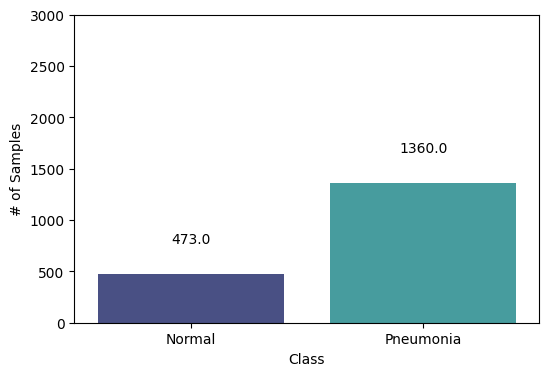

In [ ]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class")
plt.ylabel("# of Samples")
plt.ylim(0,3000)
plt.xticks([0,1], ['Normal', 'Pneumonia'])

for p in ax.patches:
    height = p.get_height()
    ax.annotate((height), (p.get_x()+p.get_width()/2, height+300), ha='center',fontsize = 10)

plt.show()




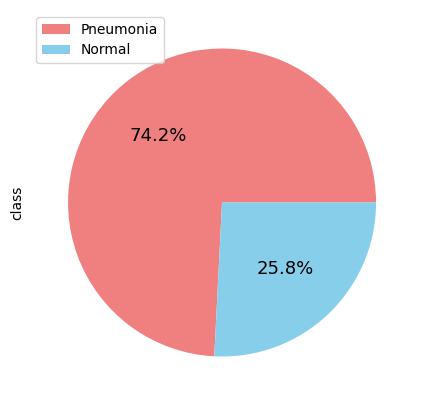

In [ ]:

plt.figure(figsize=(7, 5))

class_counts = df_train['class'].value_counts()
colors = ['lightcoral', 'skyblue']
explode = [0, 0]

class_counts.plot(kind='pie', labels=['', ''], autopct='%1.1f%%', colors=colors, explode=explode, textprops={"fontsize": 13})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()


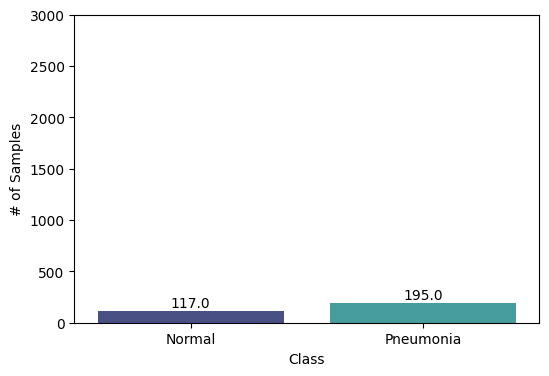

In [ ]:

plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_test, palette="mako")

plt.xlabel("Class")
plt.ylabel("# of Samples")
plt.ylim(0,3000)
plt.xticks([0,1], ['Normal', 'Pneumonia'])

for p in ax.patches:
    height = p.get_height()
    ax.annotate((height), (p.get_x()+p.get_width()/2, height+30), ha='center',fontsize = 10)

plt.show()

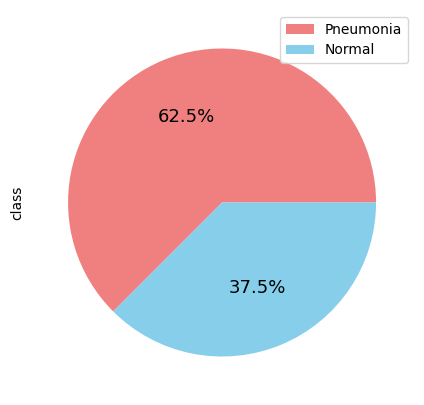

In [ ]:

plt.figure(figsize=(7, 5))

class_counts = df_test['class'].value_counts()
colors = ['lightcoral', 'skyblue']
explode = [0, 0]

class_counts.plot(kind='pie', labels=['', ''], autopct='%1.1f%%', colors=colors, explode=explode, textprops={"fontsize": 13})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()


In [ ]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [ ]:

train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,

                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,

                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,

                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 1466 validated image filenames belonging to 2 classes.
Found 367 validated image filenames belonging to 2 classes.
Found 312 validated image filenames belonging to 2 classes.


In [ ]:

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-7,
    cooldown = 0,
    verbose = 1
)


In [ ]:
def get_model():

    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    #Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    #Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[inputs], outputs=output)

    return model

In [ ]:
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 16)      64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

In [ ]:
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 4,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/4
45/45 [==============================] - 967s 21s/step - loss: 0.6299 - binary_accuracy: 0.7231 - val_loss: 0.5894 - val_binary_accuracy: 0.7411 - lr: 3.0000e-05
Epoch 2/4
45/45 [==============================] - 184s 4s/step - loss: 0.4439 - binary_accuracy: 0.7974 - val_loss: 0.6201 - val_binary_accuracy: 0.7411 - lr: 3.0000e-05
Epoch 3/4
46/45 [==============================] - ETA: 0s - loss: 0.3895 - binary_accuracy: 0.8206
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
45/45 [==============================] - 179s 4s/step - loss: 0.3895 - binary_accuracy: 0.8206 - val_loss: 0.8851 - val_binary_accuracy: 0.7411 - lr: 3.0000e-05
Epoch 4/4
45/45 [==============================] - 179s 4s/step - loss: 0.3428 - binary_accuracy: 0.8506 - val_loss: 1.0506 - val_binary_accuracy: 0.7411 - lr: 6.0000e-06


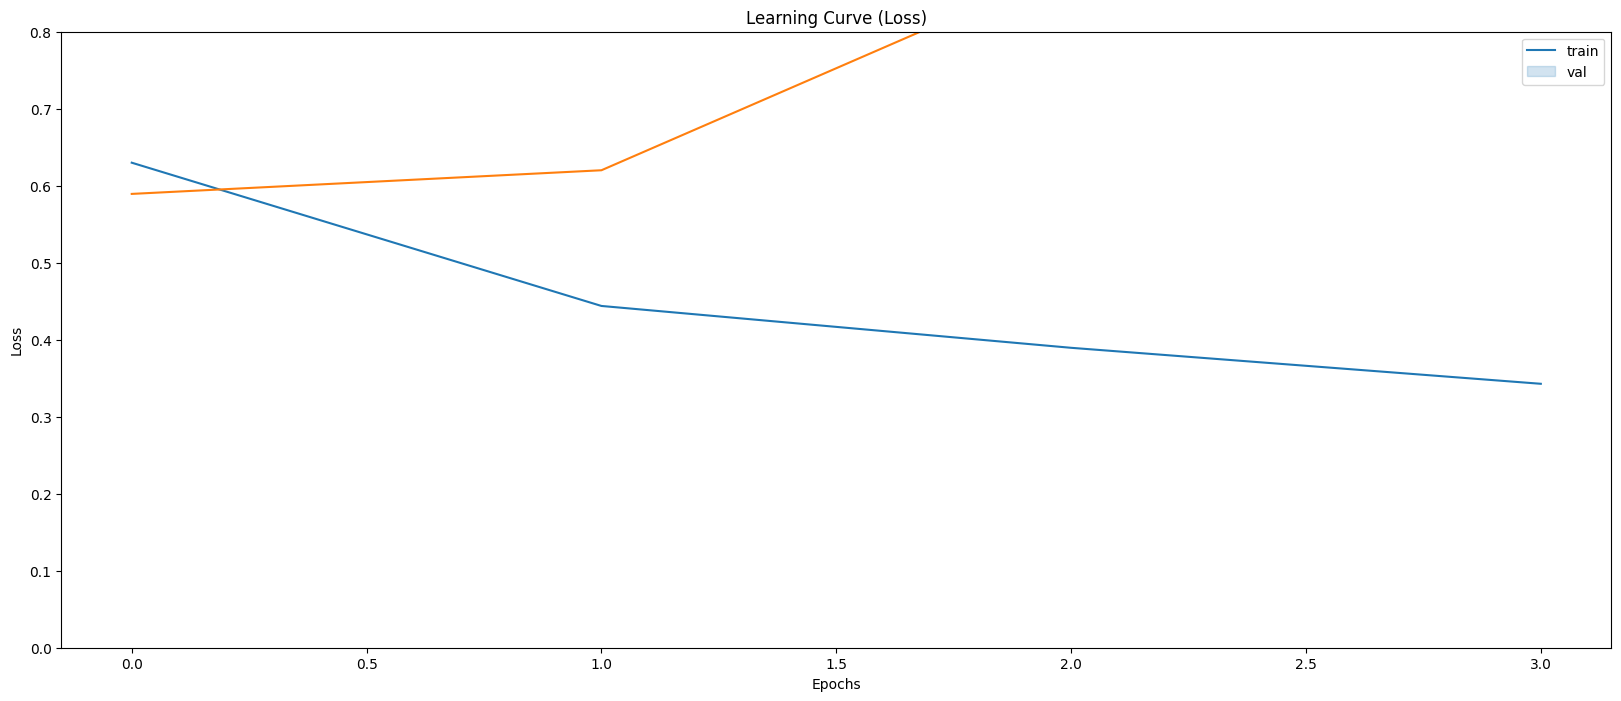

In [ ]:

fig, ax = plt.subplots(figsize=(20, 8))

sns.lineplot(x=history.epoch, y=history.history['loss'],label='Training Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'],label='Validation Loss')

ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
ax.set_ylim(0, 0.8)
ax.legend(['train', 'val'], loc='best')

plt.show()


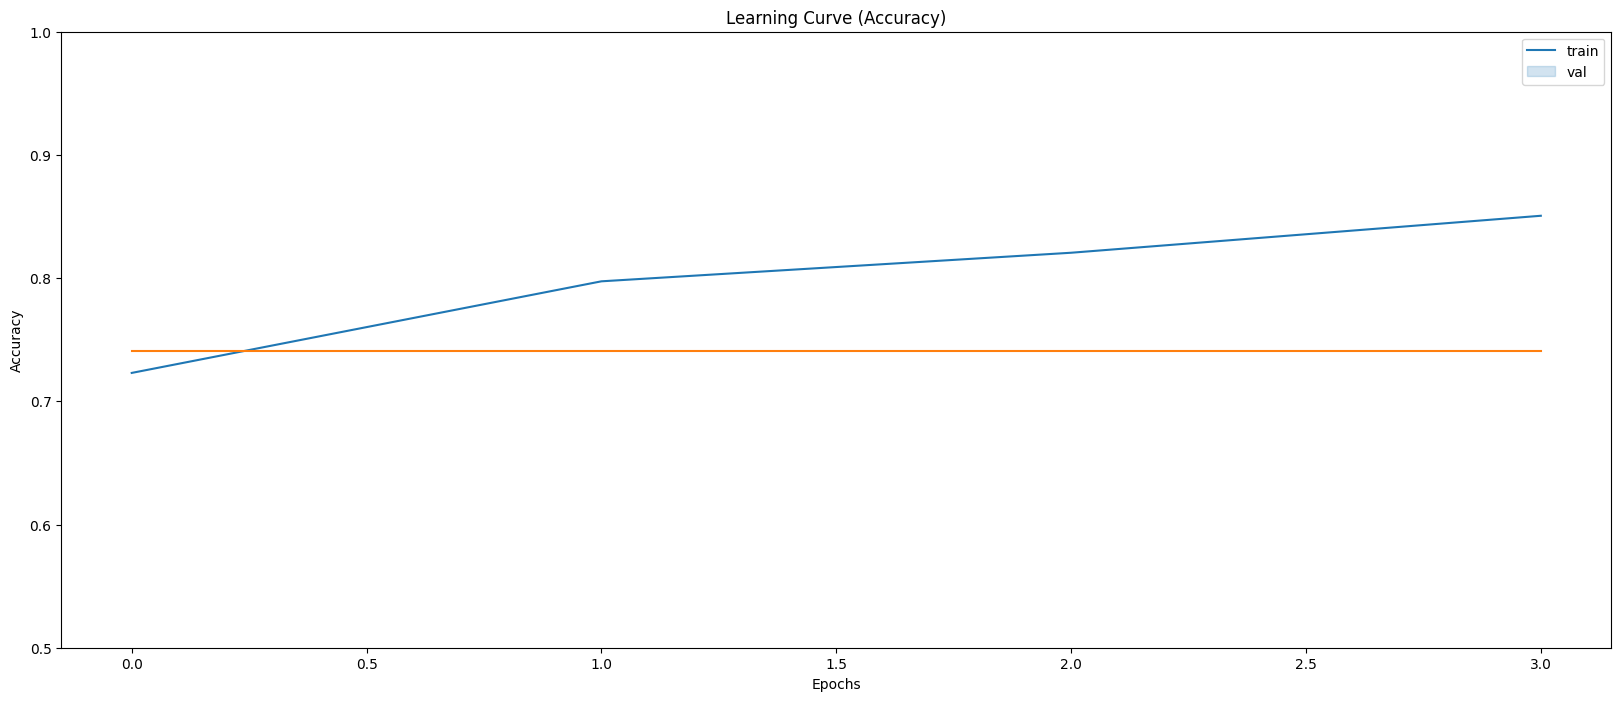

In [ ]:


fig, ax = plt.subplots(figsize=(20, 8))

sns.lineplot(x=history.epoch, y=history.history['binary_accuracy'],label='Training Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_binary_accuracy'],label='Validation Accuracy')

ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylim(0.50, 1.0)
ax.legend(['train', 'val'], loc='best')

plt.show()

In [ ]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 1.050563931465149
Val accuracy: 0.7411444187164307


In [ ]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.5414371490478516
Test accuracy: 0.625


TRANSFER LEARNING USING RESNET15


In [ ]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = base_model(inputs)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)


    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[inputs], outputs=output)

    return model

In [ ]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [ ]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 4,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/4
45/45 [==============================] - 1147s 25s/step - loss: 0.5213 - binary_accuracy: 0.7613 - val_loss: 0.3270 - val_binary_accuracy: 0.8910 - lr: 5.0000e-05
Epoch 2/4
45/45 [==============================] - 1003s 22s/step - loss: 0.3136 - binary_accuracy: 0.8663 - val_loss: 0.2315 - val_binary_accuracy: 0.9292 - lr: 5.0000e-05
Epoch 3/4
45/45 [==============================] - 971s 21s/step - loss: 0.2607 - binary_accuracy: 0.8977 - val_loss: 0.2001 - val_binary_accuracy: 0.9292 - lr: 5.0000e-05
Epoch 4/4
45/45 [==============================] - 954s 21s/step - loss: 0.2304 - binary_accuracy: 0.9141 - val_loss: 0.1931 - val_binary_accuracy: 0.9210 - lr: 5.0000e-05


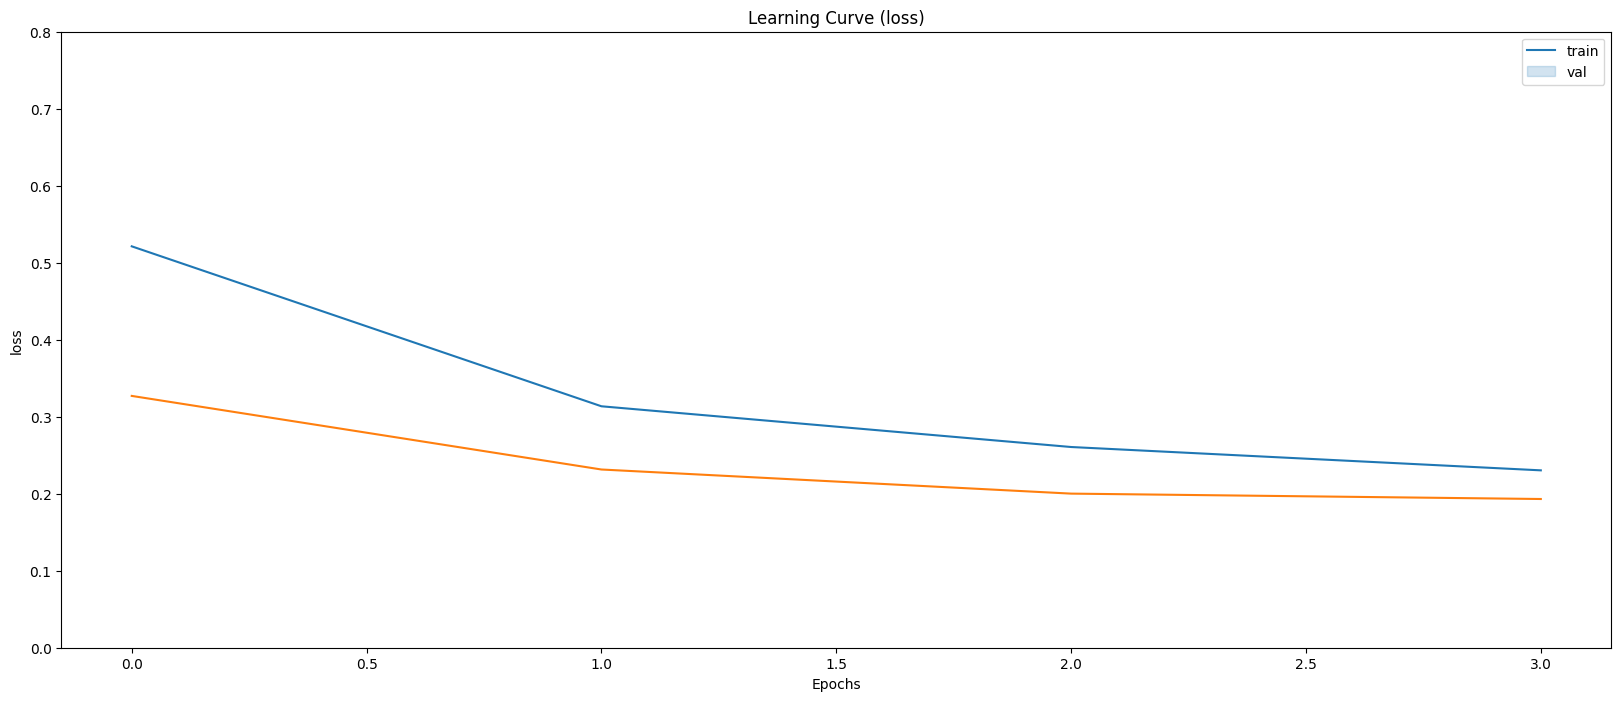

In [ ]:


fig, ax = plt.subplots(figsize=(20, 8))

sns.lineplot(x=history.epoch, y=history.history['loss'],label='Training loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'],label='Validation loss')

ax.set_title('Learning Curve (loss)')
ax.set_ylabel('loss')
ax.set_xlabel('Epochs')
ax.set_ylim(0, 0.8)
ax.legend(['train', 'val'], loc='best')

plt.show()

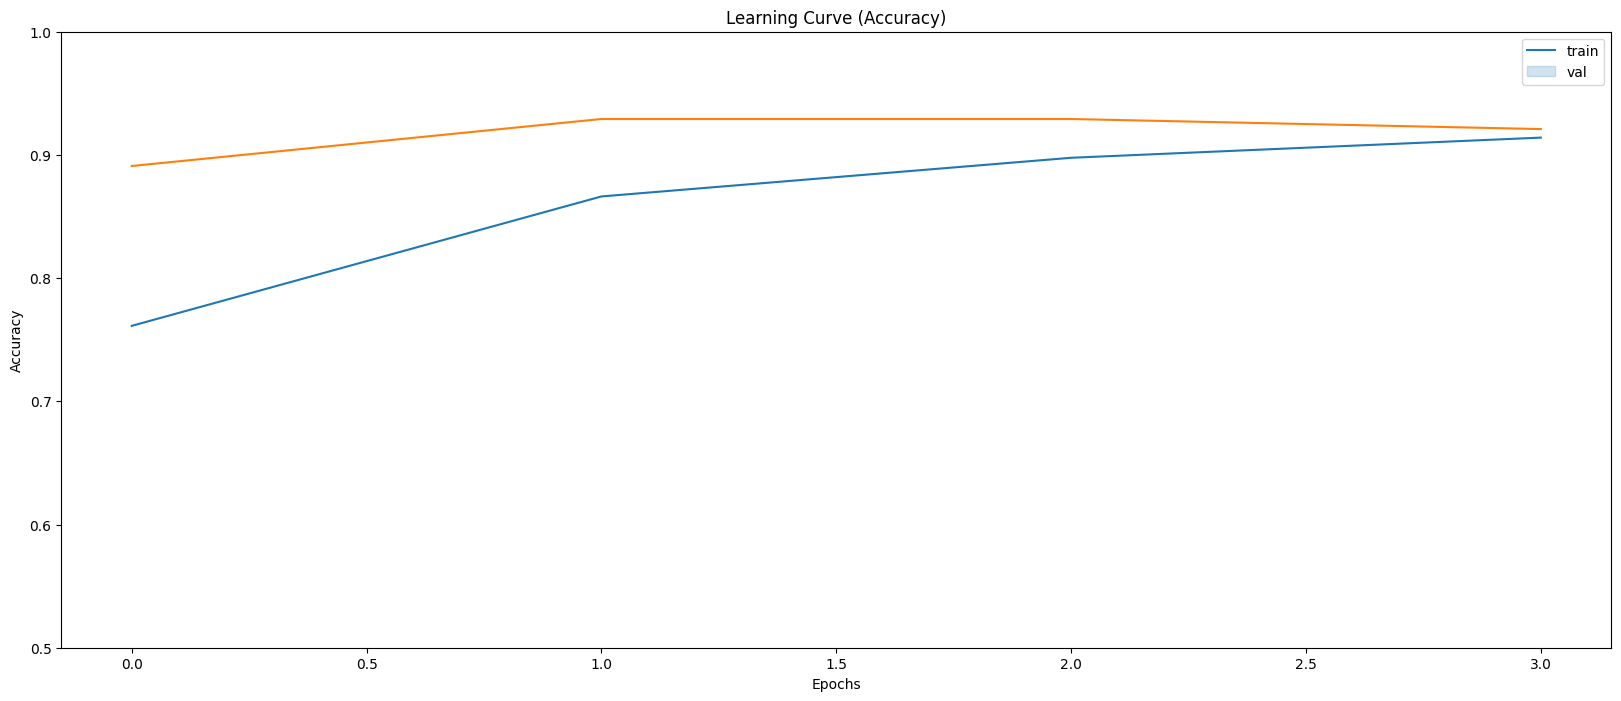

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))

sns.lineplot(x=history.epoch, y=history.history['binary_accuracy'],label='Training Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_binary_accuracy'],label='Validation Accuracy')

ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylim(0.50, 1.0)
ax.legend(['train', 'val'], loc='best')

plt.show()

In [ ]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.19314154982566833
Val accuracy: 0.9209809303283691


In [ ]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.31649190187454224
Test accuracy: 0.875


FINE TUNING

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-13]:
    layer.trainable = False

In [ ]:

# for layer_number, layer in enumerate(base_model.layers):
#     print(layer_number, layer.name, layer.trainable)

In [ ]:
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=2e-6), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [ ]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 4,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/4
45/45 [==============================] - 1006s 22s/step - loss: 0.3684 - binary_accuracy: 0.9134 - val_loss: 0.2078 - val_binary_accuracy: 0.9428 - lr: 2.0000e-06
Epoch 2/4
45/45 [==============================] - 987s 22s/step - loss: 0.3439 - binary_accuracy: 0.8956 - val_loss: 0.2415 - val_binary_accuracy: 0.9482 - lr: 2.0000e-06
Epoch 3/4
46/45 [==============================] - ETA: -3s - loss: 0.3192 - binary_accuracy: 0.9106
Epoch 3: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.
45/45 [==============================] - 980s 21s/step - loss: 0.3192 - binary_accuracy: 0.9106 - val_loss: 0.2527 - val_binary_accuracy: 0.9482 - lr: 2.0000e-06
Epoch 4/4
45/45 [==============================] - 1001s 22s/step - loss: 0.3120 - binary_accuracy: 0.9120 - val_loss: 0.2638 - val_binary_accuracy: 0.9537 - lr: 4.0000e-07


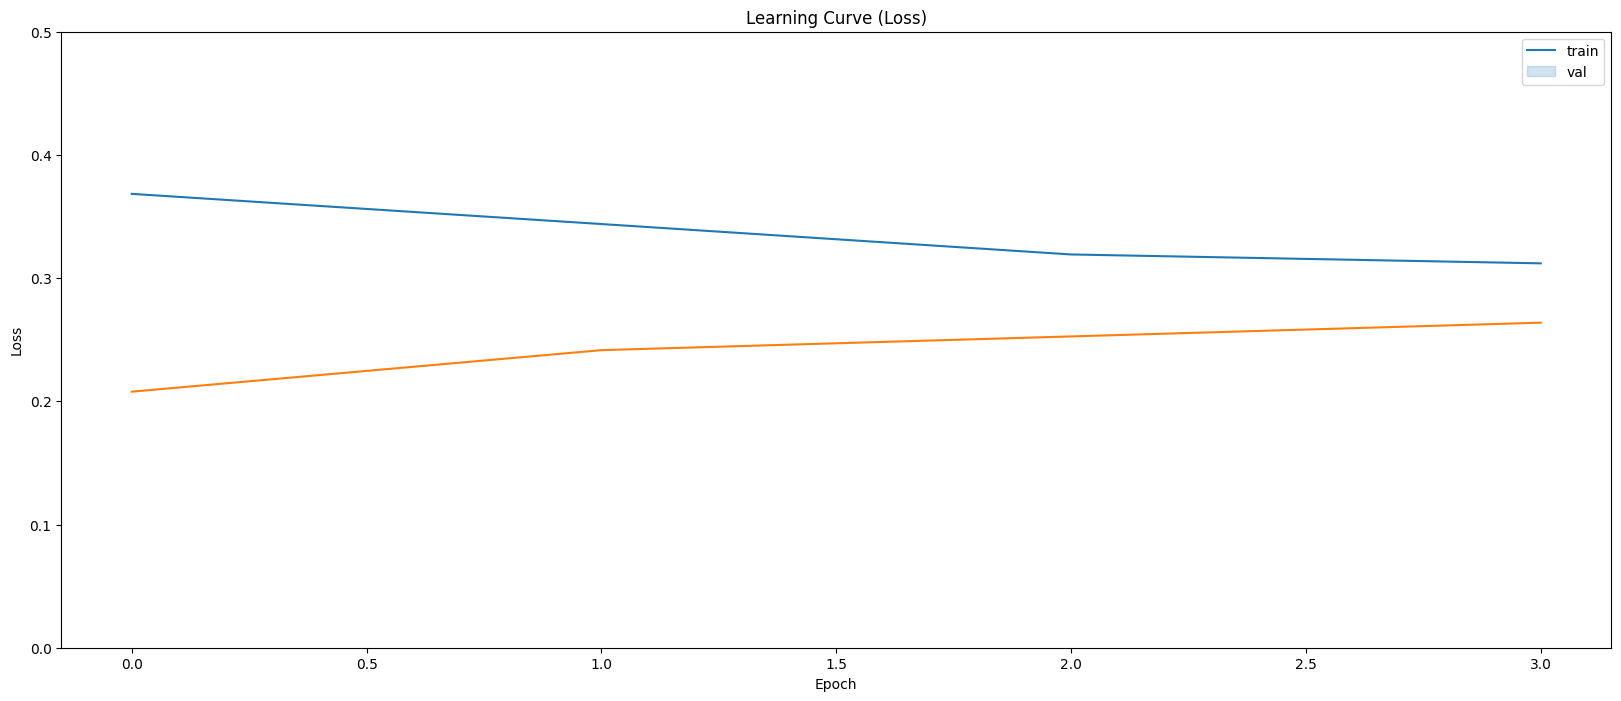

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

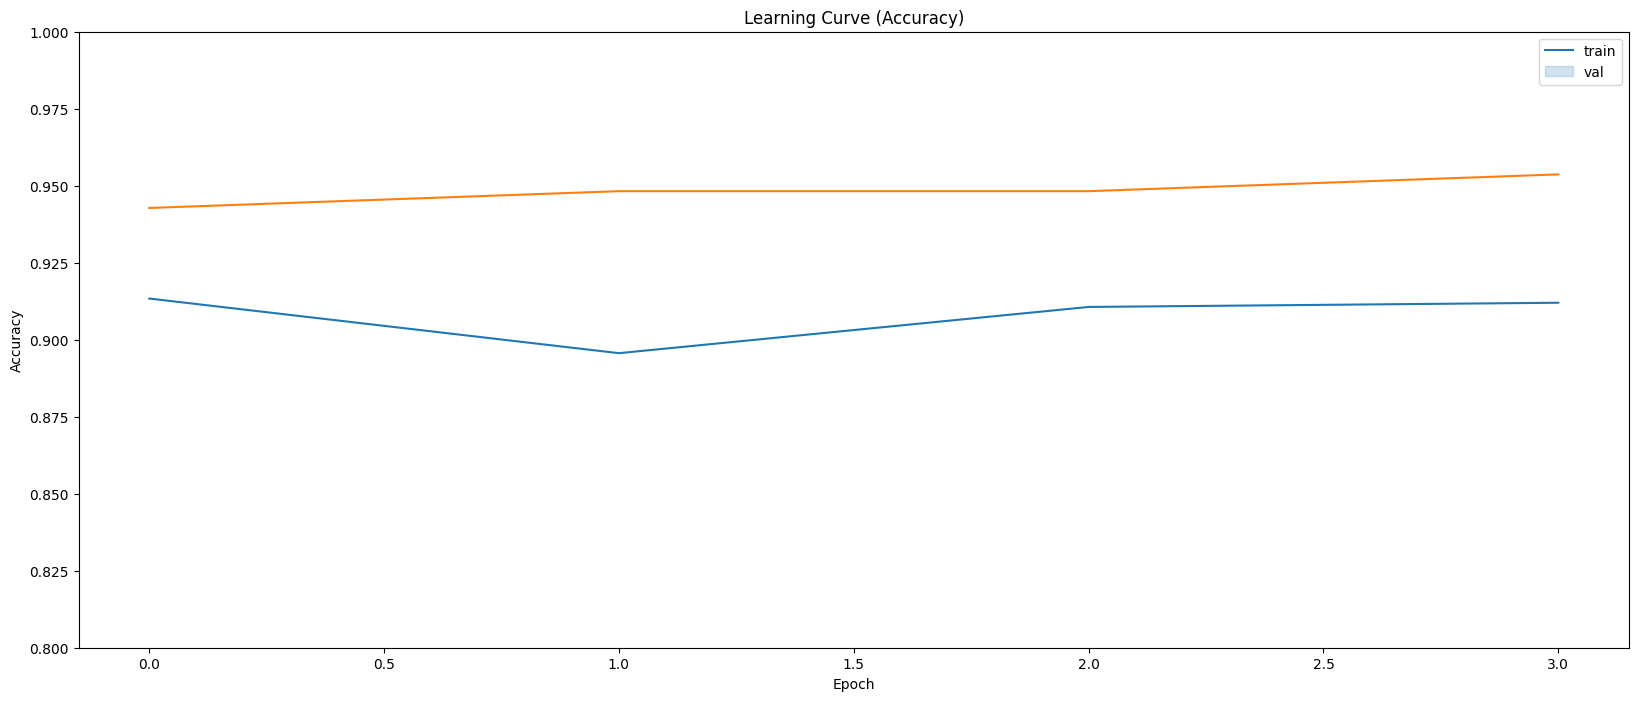

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.2638341784477234
Val accuracy: 0.9536784887313843


In [ ]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.41024938225746155
Test accuracy: 0.7948718070983887


PERFORMANCE METRICS

In [ ]:
df_test

,class,image
0,NORMAL,/content/drive/MyDrive/CM/chest_xray/test/NORMAL/NORMAL-4955194-0001.jpeg
1,NORMAL,/content/drive/MyDrive/CM/chest_xray/test/NORMAL/NORMAL-5388550-0001.jpeg
2,NORMAL,/content/drive/MyDrive/CM/chest_xray/test/NORMAL/NORMAL-5349917-0001.jpeg
3,NORMAL,/content/drive/MyDrive/CM/chest_xray/test/NORMAL/NORMAL-5175014-0001.jpeg
4,NORMAL,/content/drive/MyDrive/CM/chest_xray/test/NORMAL/NORMAL-5180957-0001.jpeg
...,...,...
307,PNEUMONIA,/content/drive/MyDrive/CM/chest_xray/test/PNEUMONIA/VIRUS-9584831-0001.jpeg
308,PNEUMONIA,/content/drive/MyDrive/CM/chest_xray/test/PNEUMONIA/VIRUS-9325276-0001.jpeg
309,PNEUMONIA,/content/drive/MyDrive/CM/chest_xray/test/PNEUMONIA/VIRUS-8427429-0001.jpeg
310,PNEUMONIA,/content/drive/MyDrive/CM/chest_xray/test/PNEUMONIA/VIRUS-9671740-0001.jpeg


In [ ]:
num_label = {"NORMAL": 0, "PNEUMONIA" : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')
# Y_test = df_test['class'].copy().map(num_label)
Y_test

0      0
1      0
2      0
3      0
4      0
      ..
307    1
308    1
309    1
310    1
311    1
Name: class, Length: 312, dtype: int64

In [ ]:
ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [ ]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.7948717948717948


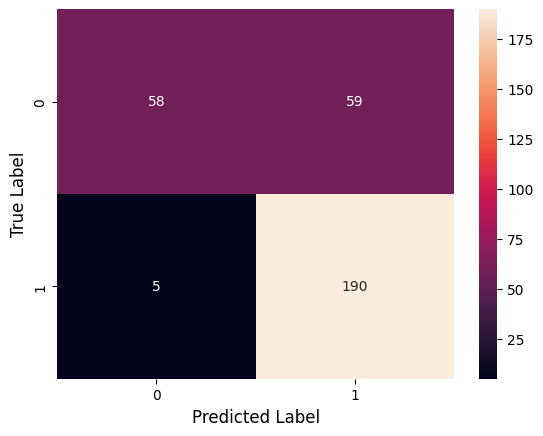

In [ ]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [ ]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.92      0.50      0.64       117
           1       0.76      0.97      0.86       195

    accuracy                           0.79       312
   macro avg       0.84      0.74      0.75       312
weighted avg       0.82      0.79      0.78       312



ROC_AUC:  0.9270216962524654


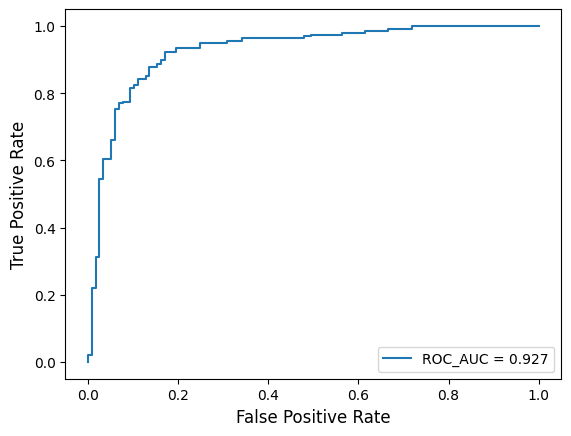

In [ ]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

In [ ]:
model_pretrained.save('model_pretrained.h5')

# loaded_model = tf.keras.models.load_model('model_pretrained.h5', compile=False)
# loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
# image_path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1001.jpeg'
# image = Image.open(image_path)

# img = image.resize((224, 224))
# img_array = tf.keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)

# predictions = loaded_model.predict(img_array)
# class_labels = classes
# score = tf.nn.softmax(predictions[0])
# print(f"{class_labels[tf.argmax(score)]}")

In [15]:
from keras.preprocessing import image

loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/CM/model_pretrained.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
image_path = "/content/drive/MyDrive/CM/chest_xray/test/PNEUMONIA/BACTERIA-8190872-0005.jpeg"
# image_path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1001.jpeg'
img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))


img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

single_img_datagen = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

augmented_images = single_img_datagen.flow(img_array, batch_size=1)


augmented_image = augmented_images.next()
predictions = loaded_model.predict(img_array)
pred_labels= np.where(predictions>0.5, 1, 0)
classes = ["NORMAL","PNEUMONIA"]
class_labels = classes
ans = "blehh"
if (pred_labels[0][0]==0):
  ans = "NORMAL"
else:
  ans = "PNEUMONIA"
print(pred_labels)
print(ans)




1/1 [==============================] - 4s 4s/step
[[1]]
PNEUMONIA
